In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([]) # type: ignore
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, c=None):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([]) # type: ignore
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c='blue' if c is None else c, s=3)
    plt.show()



1.12.0


In [2]:
import torch
from torch import nn, Tensor
import numpy as np
from torch_geometric.nn import knn
from torch_scatter import scatter
from torch_geometric.nn import Linear, MLP, PointTransformerConv, fps, knn, knn_graph, knn_interpolate
from torch_geometric.utils import scatter
import torch.nn.functional as F
from itertools import pairwise
import typing as ty
from torch_geometric.typing import OptTensor, Adj


class TransformerBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, hidden_channels: int|None = None, last_act: str = 'silu'):
        super().__init__()
        hidden_channels = hidden_channels or out_channels

        self.input_fc = MLP([in_channels, in_channels], act='silu') 
        self.point_transformer = PointTransformerConv(
            in_channels, hidden_channels,
            pos_nn=MLP([3, 64, out_channels], norm=None, plain_last=False),
            attn_nn=MLP([in_channels, 64, out_channels], norm=None, plain_last=False)
        )
        
        self.time_fc = MLP([time_channels, hidden_channels], act='silu')
        self.output_fc = MLP([hidden_channels, out_channels], act=last_act) 

        

    def forward(self, x: Tensor, t: Tensor, pos: Tensor, edge_index):
        x = self.input_fc(x)
        x = self.point_transformer(x, pos, edge_index)
        x = self.output_fc(x)
        return x


class TransitionDown(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, ratio=0.5, k=16, act='silu'):
        super().__init__()
        self.k = k
        self.ratio = ratio
        self.mlp = MLP([in_channels, out_channels], plain_last=False, act=act)

    def forward(self, x: Tensor, pos: Tensor, batch):
        id_clusters = fps(pos, ratio=self.ratio, batch=batch)
        sub_batch = batch[id_clusters] if batch is not None else None
        id_k_neighbor = knn(pos, pos[id_clusters], k=self.k, batch_x=batch, batch_y=sub_batch)
        x = self.mlp(x)
        x_out = scatter(x[id_k_neighbor[1]], id_k_neighbor[0], dim=0, dim_size=id_clusters.size(0), reduce='max')
        sub_pos, out = pos[id_clusters], x_out
        return out, sub_pos, sub_batch



class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()     
        self.mlp_sub = MLP([in_channels, out_channels], plain_last=False)
        self.mlp = MLP([out_channels, out_channels], plain_last=False)                                        
  
    def forward(self, x, x_sub, pos, pos_sub, batch=None, batch_sub=None):
        x_sub = self.mlp_sub(x_sub)                                                                           
        x_interpolated = knn_interpolate(x_sub, pos_sub, pos, k=3, batch_x=batch_sub, batch_y=batch)                                    
        x = self.mlp(x) + x_interpolated                                                                      
  
        return x


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, ratio: float=0.5, k=16):
        super().__init__()
        self.k = k
        self.transition_down = TransitionDown(in_channels, out_channels, ratio, k, act='silu')
        self.transformer = TransformerBlock(out_channels, out_channels, time_channels, last_act='silu')

    def forward(self, x: Tensor, t: Tensor, pos: Tensor, batch: OptTensor=None):
        x, pos, batch = self.transition_down(x=x, pos=pos, batch=batch)
        edge_index = knn_graph(pos, k=self.k, batch=batch)
        x = self.transformer(x=x, t=t[batch], pos=pos, edge_index=edge_index)
        return x, pos, batch


class MLPBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, k: int=16, norm: str | None='batch_norm'):
        super().__init__()
        self.k = k
        self.mlp = MLP([in_channels, out_channels], plain_last=False, norm=norm)
        self.transformer = TransformerBlock(out_channels, out_channels, time_channels)

    def forward(self, x: Tensor, t: Tensor, pos: Tensor, batch: OptTensor=None):
        x = self.mlp(x)
        edge_index = knn_graph(pos, k=self.k, batch=batch)
        x = self.transformer(x=x, t=t[batch], pos=pos, edge_index=edge_index)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels):
        super().__init__()
        self.transition_up = TransitionUp(in_channels, out_channels)
        self.transformer = TransformerBlock(out_channels, out_channels, time_channels)

    def forward(self, x: Tensor, x_sub: Tensor, t: Tensor, pos: Tensor, pos_sub: Tensor, batch=None, batch_sub=None):
        x = self.transition_up(x, x_sub, pos, pos_sub, batch, batch_sub)
        edge_index = knn_graph(pos, k=16, batch=batch)
        x = self.transformer(x=x, t=t[batch], pos=pos, edge_index=edge_index)
        return x, pos, batch

In [5]:
from embeddings import SigmaEmbedding, SigmaProjection


class DenoisingUNet(nn.Module):
    def __init__(
        self, 
        channels: int, 
        dim_model: tuple[int, ...], 
        k: int = 16
    ):
        super().__init__()
        time_channels = 4 * dim_model[0]
        self.time_projection = SigmaProjection(dim_model[0], True, 0)
        self.time_embedding = SigmaEmbedding(dim_model[0], time_channels)

        self.input_block = MLPBlock(in_channels=channels, out_channels=dim_model[0], time_channels=time_channels, k=k)
        self.down_blocks = nn.ModuleList([
            DownBlock(in_channels=upper, out_channels=lower, time_channels=time_channels, ratio=0.5, k=k) 
                for upper, lower in pairwise(dim_model)])
        
        self.summit_block = MLPBlock(in_channels=dim_model[-1], out_channels=dim_model[-1], time_channels=time_channels, k=k, norm=None)
        self.up_blocks = nn.ModuleList([
            UpBlock(in_channels=lower, out_channels=upper, time_channels=time_channels) 
                for lower, upper in pairwise(reversed(dim_model))])
        
        self.mlp_output = MLP([dim_model[0], 64, channels], norm=None, act='tanh')


    def forward(self, pos: Tensor, t: Tensor, batch: OptTensor=None):
        t = self.time_projection(t)
        t = self.time_embedding(t)
        
        x: Tensor
        x = self.input_block(x=pos, t=t, pos=pos, batch=batch)

        left_outputs = [] 
        for down_block in self.down_blocks:
            left_outputs.append((x, pos, batch))
            x, pos, batch = down_block(x=x, t=t, pos=pos, batch=batch)
            
        x = self.summit_block(x=x, t=t, pos=pos, batch=batch) 

        for up_block, left_output in zip(self.up_blocks, reversed(left_outputs)):
            left_x, left_pos, left_batch = left_output
            x, pos, batch = up_block(x=left_x, x_sub=x, t=t, pos=left_pos, pos_sub=pos, batch=left_batch, batch_sub=batch)
        
        x = self.mlp_output(x)
        return x
    


In [3]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader

path = "data/ShapeNet"
category = 'Airplane' 
transform = T.Compose([
    T.FixedPoints(1024),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2),
])
pre_transform = T.NormalizeScale()
train_dataset = ShapeNet(path, category, split='trainval', transform=transform, pre_transform=pre_transform)
test_dataset = ShapeNet(path, category, split='test', pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [9]:
from pytorch3d.loss import chamfer_distance
from torch_geometric.utils import to_dense_batch
from torch import nn

class CDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target, batch):
        pred, target = to_dense_batch(pred, batch)[0], to_dense_batch(target, batch)[0]
        return chamfer_distance(pred, target, batch_reduction=None)[0]


In [11]:
sample = next(iter(train_loader))
pos, batch = sample.pos, sample.batch

loss = CDLoss()
loss.forward(pos, pos + 1.0, batch)

tensor([3.3658, 3.0000, 3.4476, 3.7376, 3.5161, 4.0123, 3.0186, 3.2586, 3.9449,
        3.9355])

Epoch: 1, Subepoch: 0 Loss: 0.1119086816906929


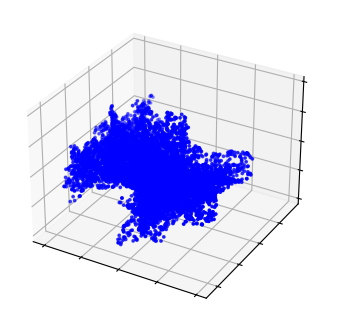

Epoch: 1, Subepoch: 10 Loss: 0.03865357115864754
Epoch: 1, Subepoch: 20 Loss: 0.06131448969244957
Epoch: 1, Subepoch: 30 Loss: 0.0705486387014389
Epoch: 1, Subepoch: 40 Loss: 0.04588581249117851
Epoch: 1, Subepoch: 50 Loss: 0.049768686294555664
Epoch: 1, Subepoch: 60 Loss: 0.03268374875187874
Epoch: 1, Subepoch: 70 Loss: 0.019645467400550842
Epoch: 1, Subepoch: 80 Loss: 0.026045741513371468
Epoch: 1, Subepoch: 90 Loss: 0.019660331308841705
Epoch: 1, Subepoch: 100 Loss: 0.04220423102378845


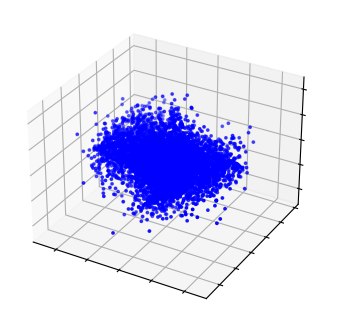

Epoch: 1, Subepoch: 110 Loss: 0.010016975924372673
Epoch: 1, Subepoch: 120 Loss: 0.015132207423448563
Epoch: 1, Subepoch: 130 Loss: 0.00525608379393816
Epoch: 1, Subepoch: 140 Loss: 0.03658576309680939
Epoch: 1, Subepoch: 150 Loss: 0.02737511321902275
Epoch: 1, Subepoch: 160 Loss: 0.005244110710918903
Epoch: 1, Subepoch: 170 Loss: 0.012340431101620197
Epoch: 1, Subepoch: 180 Loss: 0.0023843185044825077
Epoch: 1, Subepoch: 190 Loss: 0.022479146718978882
Epoch: 1, Subepoch: 200 Loss: 0.021803077310323715


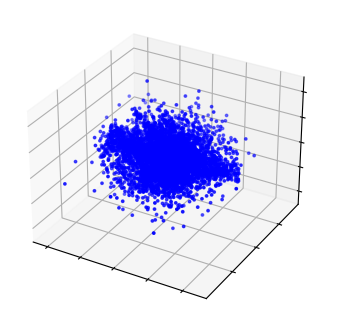

Epoch: 1, Subepoch: 210 Loss: 0.024749042466282845
Epoch: 1, Subepoch: 220 Loss: 0.01678536832332611
Epoch: 1, Subepoch: 230 Loss: 0.018734047189354897
Epoch: 2, Subepoch: 0 Loss: 0.006310281343758106


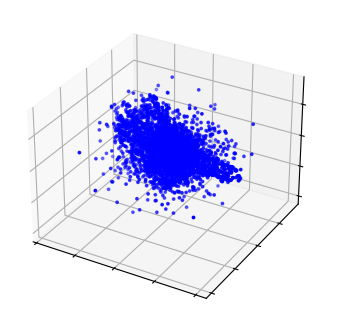

Epoch: 2, Subepoch: 10 Loss: 0.006604402791708708
Epoch: 2, Subepoch: 20 Loss: 0.015592418611049652
Epoch: 2, Subepoch: 30 Loss: 0.024294691160321236
Epoch: 2, Subepoch: 40 Loss: 0.01585107482969761
Epoch: 2, Subepoch: 50 Loss: 0.011353285051882267
Epoch: 2, Subepoch: 60 Loss: 0.009036078117787838
Epoch: 2, Subepoch: 70 Loss: 0.0130996098741889
Epoch: 2, Subepoch: 80 Loss: 0.007861966267228127
Epoch: 2, Subepoch: 90 Loss: 0.014231924898922443
Epoch: 2, Subepoch: 100 Loss: 0.02249602973461151


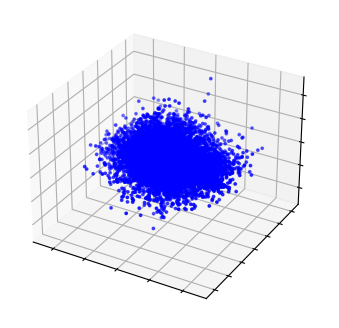

Epoch: 2, Subepoch: 110 Loss: 0.00809597410261631
Epoch: 2, Subepoch: 120 Loss: 0.007892543449997902
Epoch: 2, Subepoch: 130 Loss: 0.012622303329408169
Epoch: 2, Subepoch: 140 Loss: 0.011533444747328758
Epoch: 2, Subepoch: 150 Loss: 0.012780576013028622
Epoch: 2, Subepoch: 160 Loss: 0.018058428540825844
Epoch: 2, Subepoch: 170 Loss: 0.005504922941327095
Epoch: 2, Subepoch: 180 Loss: 0.00810471922159195
Epoch: 2, Subepoch: 190 Loss: 0.00502370810136199
Epoch: 2, Subepoch: 200 Loss: 0.010406050831079483


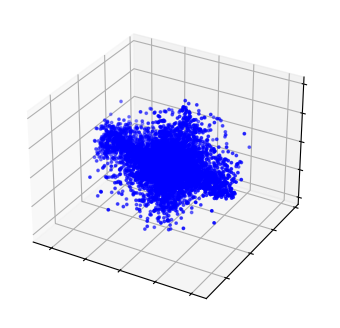

Epoch: 2, Subepoch: 210 Loss: 0.005155164748430252
Epoch: 2, Subepoch: 220 Loss: 0.005929483566433191
Epoch: 2, Subepoch: 230 Loss: 0.006483444944024086
Epoch: 3, Subepoch: 0 Loss: 0.009116454049944878


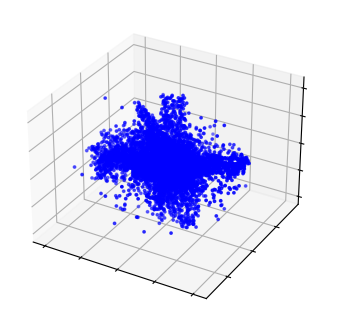

Epoch: 3, Subepoch: 10 Loss: 0.013062972575426102
Epoch: 3, Subepoch: 20 Loss: 0.005349611397832632
Epoch: 3, Subepoch: 30 Loss: 0.0118015231564641
Epoch: 3, Subepoch: 40 Loss: 0.016263900324702263
Epoch: 3, Subepoch: 50 Loss: 0.004397149197757244
Epoch: 3, Subepoch: 60 Loss: 0.005678809713572264
Epoch: 3, Subepoch: 70 Loss: 0.007893865928053856
Epoch: 3, Subepoch: 80 Loss: 0.008557170629501343
Epoch: 3, Subepoch: 90 Loss: 0.006519845686852932
Epoch: 3, Subepoch: 100 Loss: 0.006943596992641687


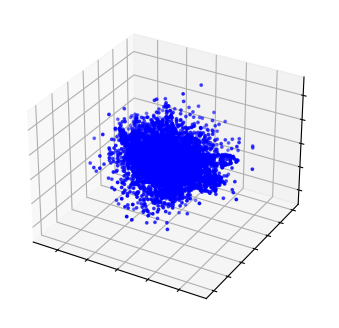

Epoch: 3, Subepoch: 110 Loss: 0.007036631461232901
Epoch: 3, Subepoch: 120 Loss: 0.008774294517934322
Epoch: 3, Subepoch: 130 Loss: 0.005067544989287853
Epoch: 3, Subepoch: 140 Loss: 0.007677378598600626
Epoch: 3, Subepoch: 150 Loss: 0.008669791743159294
Epoch: 3, Subepoch: 160 Loss: 0.003463425673544407
Epoch: 3, Subepoch: 170 Loss: 0.00757855549454689
Epoch: 3, Subepoch: 180 Loss: 0.007912720553576946
Epoch: 3, Subepoch: 190 Loss: 0.010337264277040958
Epoch: 3, Subepoch: 200 Loss: 0.008924918249249458


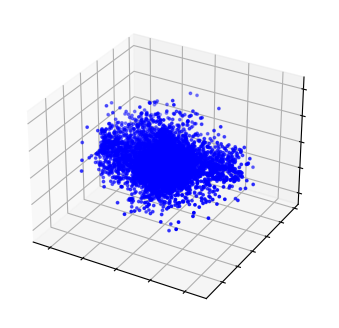

Epoch: 3, Subepoch: 210 Loss: 0.005935982335358858
Epoch: 3, Subepoch: 220 Loss: 0.005556918680667877
Epoch: 3, Subepoch: 230 Loss: 0.008007441647350788
Epoch: 4, Subepoch: 0 Loss: 0.0017675276612862945


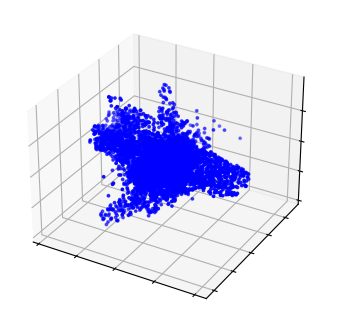

Epoch: 4, Subepoch: 10 Loss: 0.004668723326176405
Epoch: 4, Subepoch: 20 Loss: 0.008373997174203396
Epoch: 4, Subepoch: 30 Loss: 0.011646406725049019
Epoch: 4, Subepoch: 40 Loss: 0.0053918925113976
Epoch: 4, Subepoch: 50 Loss: 0.008652259595692158
Epoch: 4, Subepoch: 60 Loss: 0.005687809083610773
Epoch: 4, Subepoch: 70 Loss: 0.007091115694493055
Epoch: 4, Subepoch: 80 Loss: 0.0047093601897358894
Epoch: 4, Subepoch: 90 Loss: 0.005781771149486303
Epoch: 4, Subepoch: 100 Loss: 0.006162834819406271


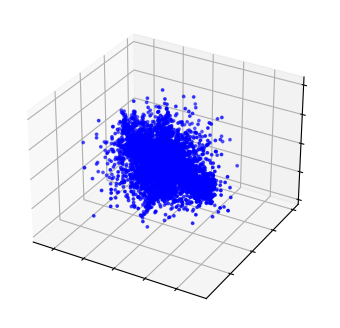

Epoch: 4, Subepoch: 110 Loss: 0.0035783331841230392
Epoch: 4, Subepoch: 120 Loss: 0.006321759428828955
Epoch: 4, Subepoch: 130 Loss: 0.009241530671715736
Epoch: 4, Subepoch: 140 Loss: 0.007540273945778608
Epoch: 4, Subepoch: 150 Loss: 0.0075749498791992664
Epoch: 4, Subepoch: 160 Loss: 0.006504850462079048
Epoch: 4, Subepoch: 170 Loss: 0.005333649925887585
Epoch: 4, Subepoch: 180 Loss: 0.006987397558987141
Epoch: 4, Subepoch: 190 Loss: 0.004972475115209818
Epoch: 4, Subepoch: 200 Loss: 0.005179708357900381


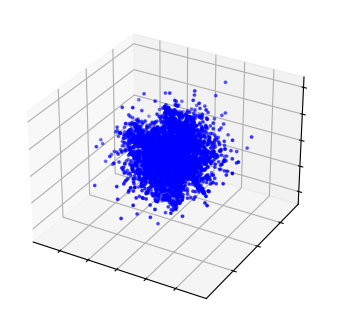

Epoch: 4, Subepoch: 210 Loss: 0.006152421236038208
Epoch: 4, Subepoch: 220 Loss: 0.0030263594817370176
Epoch: 4, Subepoch: 230 Loss: 0.005661092232912779
Epoch: 5, Subepoch: 0 Loss: 0.008250514976680279


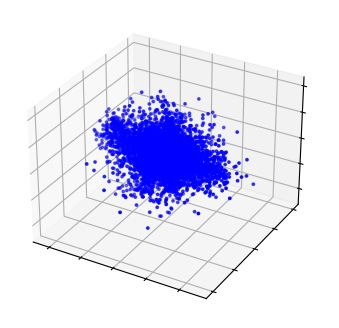

Epoch: 5, Subepoch: 10 Loss: 0.005478033795952797
Epoch: 5, Subepoch: 20 Loss: 0.00450885808095336
Epoch: 5, Subepoch: 30 Loss: 0.0045896489173173904
Epoch: 5, Subepoch: 40 Loss: 0.0039968425408005714
Epoch: 5, Subepoch: 50 Loss: 0.0032035631593316793
Epoch: 5, Subepoch: 60 Loss: 0.009094877168536186
Epoch: 5, Subepoch: 70 Loss: 0.002497212728485465
Epoch: 5, Subepoch: 80 Loss: 0.002841363428160548
Epoch: 5, Subepoch: 90 Loss: 0.008629419840872288
Epoch: 5, Subepoch: 100 Loss: 0.006876080762594938


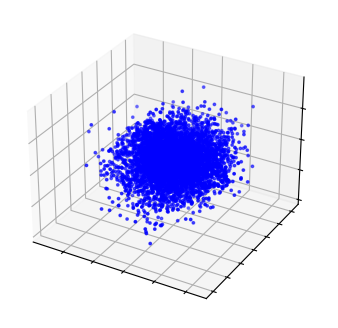

Epoch: 5, Subepoch: 110 Loss: 0.006831780541688204
Epoch: 5, Subepoch: 120 Loss: 0.0042966557666659355
Epoch: 5, Subepoch: 130 Loss: 0.005945551674813032
Epoch: 5, Subepoch: 140 Loss: 0.009285279549658298
Epoch: 5, Subepoch: 150 Loss: 0.004592008423060179
Epoch: 5, Subepoch: 160 Loss: 0.004853605292737484
Epoch: 5, Subepoch: 170 Loss: 0.0059172543697059155
Epoch: 5, Subepoch: 180 Loss: 0.006993414368480444
Epoch: 5, Subepoch: 190 Loss: 0.004815605469048023
Epoch: 5, Subepoch: 200 Loss: 0.00562796276062727


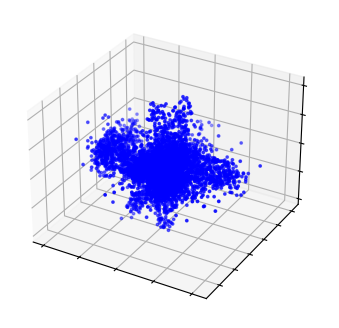

Epoch: 5, Subepoch: 210 Loss: 0.005691171158105135
Epoch: 5, Subepoch: 220 Loss: 0.005293507594615221
Epoch: 5, Subepoch: 230 Loss: 0.004896118771284819
Epoch: 6, Subepoch: 0 Loss: 0.0036743294913321733


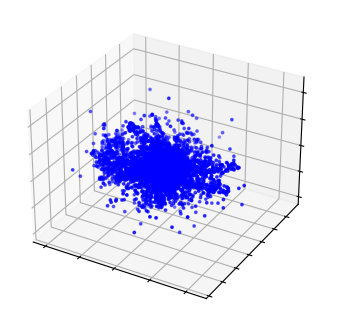

Epoch: 6, Subepoch: 10 Loss: 0.006141374818980694
Epoch: 6, Subepoch: 20 Loss: 0.007386778015643358
Epoch: 6, Subepoch: 30 Loss: 0.009489818476140499
Epoch: 6, Subepoch: 40 Loss: 0.006317453924566507
Epoch: 6, Subepoch: 50 Loss: 0.006684052292257547
Epoch: 6, Subepoch: 60 Loss: 0.005983301438391209
Epoch: 6, Subepoch: 70 Loss: 0.004454829730093479
Epoch: 6, Subepoch: 80 Loss: 0.006568554323166609
Epoch: 6, Subepoch: 90 Loss: 0.01038803718984127
Epoch: 6, Subepoch: 100 Loss: 0.00844879075884819


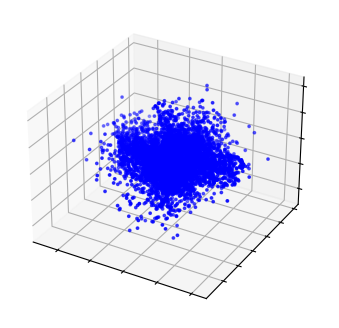

Epoch: 6, Subepoch: 110 Loss: 0.0119269834831357
Epoch: 6, Subepoch: 120 Loss: 0.007978430949151516
Epoch: 6, Subepoch: 130 Loss: 0.006324113346636295
Epoch: 6, Subepoch: 140 Loss: 0.007081032730638981
Epoch: 6, Subepoch: 150 Loss: 0.009103965945541859
Epoch: 6, Subepoch: 160 Loss: 0.007730936631560326
Epoch: 6, Subepoch: 170 Loss: 0.009658914990723133
Epoch: 6, Subepoch: 180 Loss: 0.010205257683992386
Epoch: 6, Subepoch: 190 Loss: 0.007060575298964977
Epoch: 6, Subepoch: 200 Loss: 0.005545551888644695


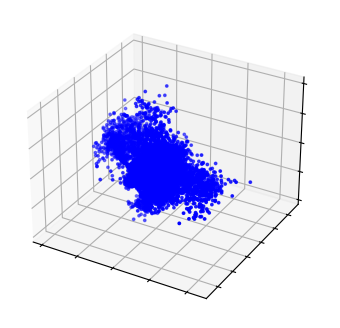

Epoch: 6, Subepoch: 210 Loss: 0.005800697486847639
Epoch: 6, Subepoch: 220 Loss: 0.008083971217274666
Epoch: 6, Subepoch: 230 Loss: 0.004794972948729992
Epoch: 7, Subepoch: 0 Loss: 0.0035161576233804226


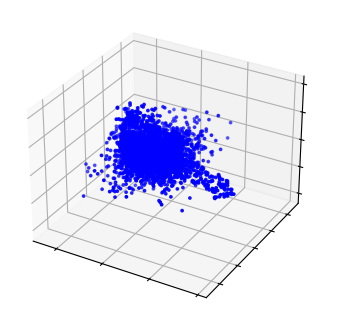

Epoch: 7, Subepoch: 10 Loss: 0.0046263509429991245
Epoch: 7, Subepoch: 20 Loss: 0.005719233304262161
Epoch: 7, Subepoch: 30 Loss: 0.005286174826323986
Epoch: 7, Subepoch: 40 Loss: 0.004961688537150621
Epoch: 7, Subepoch: 50 Loss: 0.004557275213301182
Epoch: 7, Subepoch: 60 Loss: 0.007245122920721769
Epoch: 7, Subepoch: 70 Loss: 0.009574072435498238
Epoch: 7, Subepoch: 80 Loss: 0.00679352693259716
Epoch: 7, Subepoch: 90 Loss: 0.008481757715344429
Epoch: 7, Subepoch: 100 Loss: 0.006453868001699448


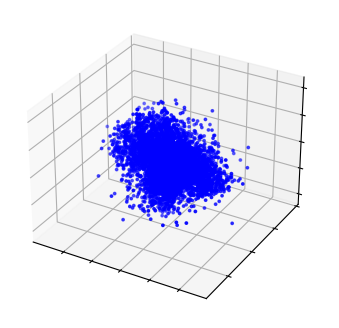

Epoch: 7, Subepoch: 110 Loss: 0.0064100646413862705
Epoch: 7, Subepoch: 120 Loss: 0.008711777627468109
Epoch: 7, Subepoch: 130 Loss: 0.011754386126995087
Epoch: 7, Subepoch: 140 Loss: 0.01569012925028801
Epoch: 7, Subepoch: 150 Loss: 0.0158599354326725
Epoch: 7, Subepoch: 160 Loss: 0.013904593884944916
Epoch: 7, Subepoch: 170 Loss: 0.008760243654251099
Epoch: 7, Subepoch: 180 Loss: 0.007389983627945185
Epoch: 7, Subepoch: 190 Loss: 0.008431516587734222
Epoch: 7, Subepoch: 200 Loss: 0.010039265267550945


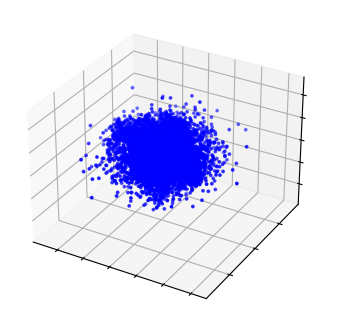

Epoch: 7, Subepoch: 210 Loss: 0.01060517132282257
Epoch: 7, Subepoch: 220 Loss: 0.010420745238661766
Epoch: 7, Subepoch: 230 Loss: 0.011739865876734257
Epoch: 8, Subepoch: 0 Loss: 0.009207161143422127


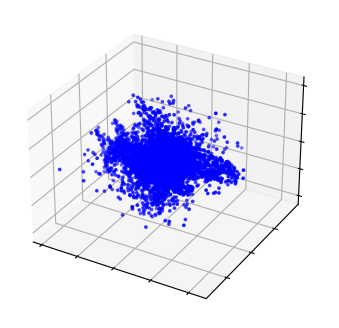

Epoch: 8, Subepoch: 10 Loss: 0.010383221320807934
Epoch: 8, Subepoch: 20 Loss: 0.00811042357236147
Epoch: 8, Subepoch: 30 Loss: 0.005740868393331766
Epoch: 8, Subepoch: 40 Loss: 0.005482771433889866
Epoch: 8, Subepoch: 50 Loss: 0.00853357557207346
Epoch: 8, Subepoch: 60 Loss: 0.00790921039879322
Epoch: 8, Subepoch: 70 Loss: 0.009179918095469475
Epoch: 8, Subepoch: 80 Loss: 0.0074616228230297565
Epoch: 8, Subepoch: 90 Loss: 0.009595966897904873
Epoch: 8, Subepoch: 100 Loss: 0.007151111960411072


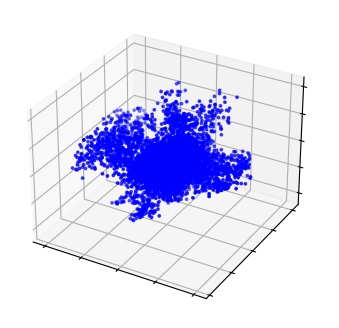

Epoch: 8, Subepoch: 110 Loss: 0.008842675015330315
Epoch: 8, Subepoch: 120 Loss: 0.00745443906635046
Epoch: 8, Subepoch: 130 Loss: 0.00630906643345952
Epoch: 8, Subepoch: 140 Loss: 0.006192632019519806
Epoch: 8, Subepoch: 150 Loss: 0.007657504640519619
Epoch: 8, Subepoch: 160 Loss: 0.006340694613754749
Epoch: 8, Subepoch: 170 Loss: 0.006821442861109972
Epoch: 8, Subepoch: 180 Loss: 0.007198766339570284
Epoch: 8, Subepoch: 190 Loss: 0.008576495572924614
Epoch: 8, Subepoch: 200 Loss: 0.008553225547075272


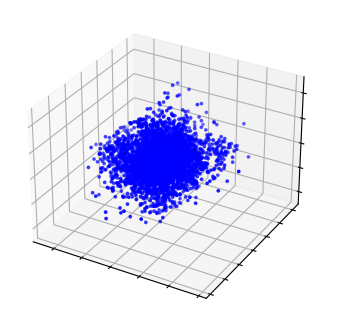

Epoch: 8, Subepoch: 210 Loss: 0.009984948672354221
Epoch: 8, Subepoch: 220 Loss: 0.011160872876644135
Epoch: 8, Subepoch: 230 Loss: 0.009774526581168175
Epoch: 9, Subepoch: 0 Loss: 0.008036913350224495


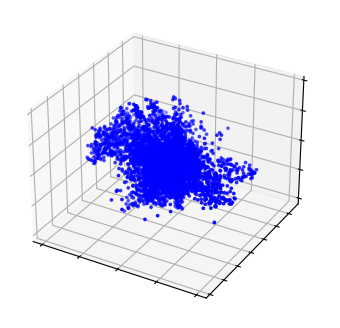

Epoch: 9, Subepoch: 10 Loss: 0.0062604257836937904
Epoch: 9, Subepoch: 20 Loss: 0.00602304469794035
Epoch: 9, Subepoch: 30 Loss: 0.005578719545155764
Epoch: 9, Subepoch: 40 Loss: 0.004325550515204668
Epoch: 9, Subepoch: 50 Loss: 0.006017407868057489
Epoch: 9, Subepoch: 60 Loss: 0.0050169797614216805
Epoch: 9, Subepoch: 70 Loss: 0.006074093282222748
Epoch: 9, Subepoch: 80 Loss: 0.005400056019425392
Epoch: 9, Subepoch: 90 Loss: 0.006983533501625061
Epoch: 9, Subepoch: 100 Loss: 0.009147421456873417


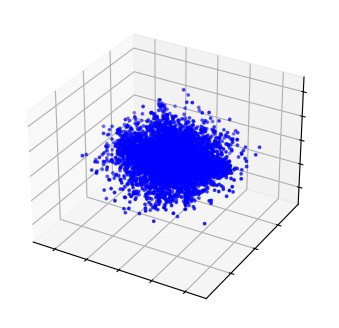

Epoch: 9, Subepoch: 110 Loss: 0.00838960986584425
Epoch: 9, Subepoch: 120 Loss: 0.0051866513676941395
Epoch: 9, Subepoch: 130 Loss: 0.0072122239507734776
Epoch: 9, Subepoch: 140 Loss: 0.00594409741461277
Epoch: 9, Subepoch: 150 Loss: 0.007758072577416897
Epoch: 9, Subepoch: 160 Loss: 0.008444545790553093
Epoch: 9, Subepoch: 170 Loss: 0.011533934623003006
Epoch: 9, Subepoch: 180 Loss: 0.009570961818099022
Epoch: 9, Subepoch: 190 Loss: 0.00693257013335824
Epoch: 9, Subepoch: 200 Loss: 0.0035422497894614935


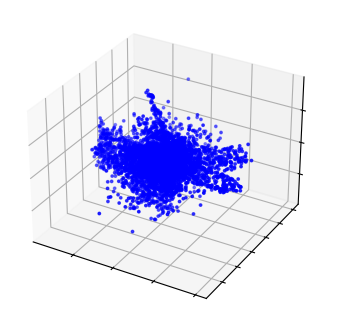

Epoch: 9, Subepoch: 210 Loss: 0.0038940561935305595
Epoch: 9, Subepoch: 220 Loss: 0.005760295316576958
Epoch: 9, Subepoch: 230 Loss: 0.009504090994596481
Epoch: 10, Subepoch: 0 Loss: 0.010083635337650776


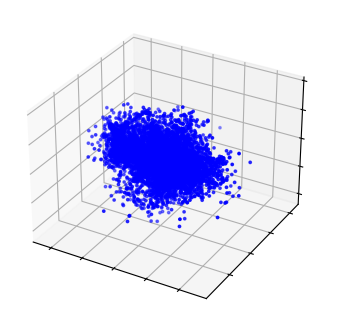

Epoch: 10, Subepoch: 10 Loss: 0.011874855495989323
Epoch: 10, Subepoch: 20 Loss: 0.009038351476192474
Epoch: 10, Subepoch: 30 Loss: 0.010268517769873142
Epoch: 10, Subepoch: 40 Loss: 0.0042145345360040665
Epoch: 10, Subepoch: 50 Loss: 0.005566094070672989
Epoch: 10, Subepoch: 60 Loss: 0.005134690552949905
Epoch: 10, Subepoch: 70 Loss: 0.006324438378214836
Epoch: 10, Subepoch: 80 Loss: 0.009100193157792091
Epoch: 10, Subepoch: 90 Loss: 0.010186023078858852
Epoch: 10, Subepoch: 100 Loss: 0.009328214451670647


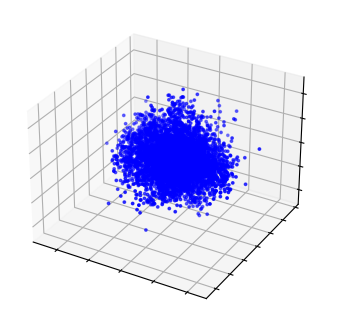

Epoch: 10, Subepoch: 110 Loss: 0.012080495245754719
Epoch: 10, Subepoch: 120 Loss: 0.009378843009471893
Epoch: 10, Subepoch: 130 Loss: 0.006651035975664854
Epoch: 10, Subepoch: 140 Loss: 0.008614120073616505
Epoch: 10, Subepoch: 150 Loss: 0.007695191074162722
Epoch: 10, Subepoch: 160 Loss: 0.005675781052559614
Epoch: 10, Subepoch: 170 Loss: 0.007349760737270117
Epoch: 10, Subepoch: 180 Loss: 0.006115605589002371
Epoch: 10, Subepoch: 190 Loss: 0.0073475888930261135
Epoch: 10, Subepoch: 200 Loss: 0.006979543250054121


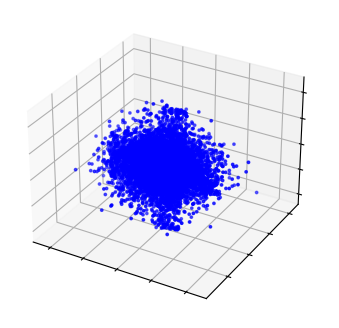

Epoch: 10, Subepoch: 210 Loss: 0.007706251461058855
Epoch: 10, Subepoch: 220 Loss: 0.008058572188019753
Epoch: 10, Subepoch: 230 Loss: 0.007719959132373333
Epoch: 11, Subepoch: 0 Loss: 0.007499470841139555


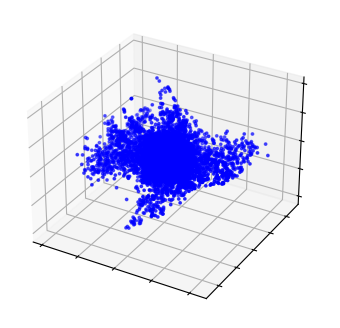

Epoch: 11, Subepoch: 10 Loss: 0.0056672412902116776
Epoch: 11, Subepoch: 20 Loss: 0.004981442354619503
Epoch: 11, Subepoch: 30 Loss: 0.003981912042945623
Epoch: 11, Subepoch: 40 Loss: 0.003500464139506221
Epoch: 11, Subepoch: 50 Loss: 0.0026673655956983566
Epoch: 11, Subepoch: 60 Loss: 0.004514042753726244
Epoch: 11, Subepoch: 70 Loss: 0.005587435327470303
Epoch: 11, Subepoch: 80 Loss: 0.009411848150193691
Epoch: 11, Subepoch: 90 Loss: 0.009516384452581406
Epoch: 11, Subepoch: 100 Loss: 0.008732619695365429


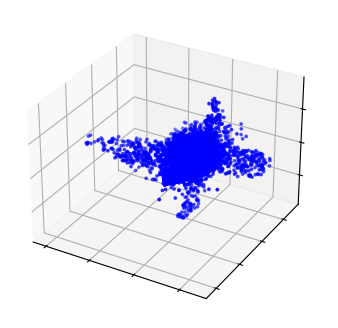

Epoch: 11, Subepoch: 110 Loss: 0.007931399159133434
Epoch: 11, Subepoch: 120 Loss: 0.004809733480215073
Epoch: 11, Subepoch: 130 Loss: 0.0038241390138864517
Epoch: 11, Subepoch: 140 Loss: 0.0060073030181229115
Epoch: 11, Subepoch: 150 Loss: 0.004124043043702841
Epoch: 11, Subepoch: 160 Loss: 0.0069327023811638355
Epoch: 11, Subepoch: 170 Loss: 0.004439927637577057
Epoch: 11, Subepoch: 180 Loss: 0.00323584396392107
Epoch: 11, Subepoch: 190 Loss: 0.005347004625946283
Epoch: 11, Subepoch: 200 Loss: 0.0033277065958827734


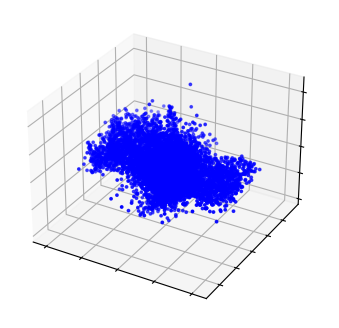

Epoch: 11, Subepoch: 210 Loss: 0.0038056555204093456
Epoch: 11, Subepoch: 220 Loss: 0.009894325397908688
Epoch: 11, Subepoch: 230 Loss: 0.0071991668082773685


KeyboardInterrupt: 

In [14]:
from consistency_models import ConsistencyTraining, timesteps_schedule, ema_decay_rate_schedule, update_ema_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

online_model = DenoisingUNet(channels=3, dim_model=(32, 64, 128, 256)).to(device)
ema_model = DenoisingUNet(channels=3, dim_model=(32, 64, 128, 256)).to(device)
ema_model.load_state_dict(online_model.state_dict())

consistency_step = ConsistencyTraining()
optimizer = torch.optim.Adam(online_model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()


online_model.train()
optimizer.zero_grad()

k = 0
max_iters = 500 * len(train_loader)
for epoch in range(1, 500):
    for i, data in enumerate(train_loader):
        data = data.to(device)
        next_x, current_x = consistency_step(online_model, ema_model, data.pos, data.batch, k, max_iters)
        
        loss = loss_fn(next_x, current_x)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'Epoch: {epoch}, Subepoch: {i} Loss: {loss.item()}')

        if i % 100 == 0:
            visualize_points(current_x.detach().cpu().numpy())
            visualize_points(next_x.detach().cpu().numpy())

        with torch.no_grad():
            num_timesteps = timesteps_schedule(epoch, 500)
            ema_decay_rate = ema_decay_rate_schedule(num_timesteps,)
            ema_model = update_ema_model(ema_model, online_model, ema_decay_rate)
            
        k += 1

tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)
